In [7]:
%pylab inline

import networkx as nx
from itertools import combinations
from collections import defaultdict
from copy import copy
import random
import datetime
import pickle, glob, os
import osmnx as ox
import numpy as np


Populating the interactive namespace from numpy and matplotlib


In [8]:
def create_grid(size):

    G = nx.grid_2d_graph(size, size)
    pos = {i:[n[0],n[1]] for i, n in enumerate(G.nodes())}
    G = nx.convert_node_labels_to_integers(G)
    G = nx.DiGraph(G)

    return G, pos


def noise(pos, noise_scale):
    for i in pos:
        dx, dy = (2*random.random()-1.) * noise_scale, (2*random.random()-1.) * noise_scale
        pos[i] = (pos[i][0]+dx, pos[i][1]+dy)
    return pos


def draw_graph(G, pos, figsize):
    figure(figsize=(figsize, figsize))
    nx.draw_networkx_edges(G, pos, alpha=0.4)
    nx.draw_networkx_nodes(G, pos, node_size=40, cmap=plt.cm.Reds_r, node_color='r')
    #_ = nx.draw_networkx_labels(G, pos, font_size=20)

    
def cos_angle_edge(p1, p0, p_list):
    d0 = (p1[0] - p0[0], p1[1] - p0[1])
    d_list = []
    for i, p in enumerate(p_list):
        d_list.append((p[0] - p0[0], p[1] - p0[1]))
    cos_dict = {}
    for (ia,a) in enumerate(d_list):
        cos_alpha = (a[0] * d0[0] + a[1] * d0[1]) /( math.sqrt(a[0]**2 + a[1]**2) * math.sqrt(d0[0]**2 + d0[1]**2) )
        
        cos_dict[ia] = -(cos_alpha)
        
    return cos_dict


def merge_edges(G, pos, thr):
    meta_edge_set = defaultdict(list)

    edge_set = set(G.edges())
    i = 0 # meta edge label
    while edge_set:
        edge = edge_set.pop() # select a random edge
        if edge[::-1] in edge_set:
            edge_2way_list = [edge, edge[::-1]] 
        else:
            edge_2way_list = [edge]
        meta_edge_set[i].append(edge) # this edge surely belongs to the metaedge

        for ii, e in enumerate(edge_2way_list): # let's follow the path in both ways
            n1, n2 = e
            joined = True
            while joined:
                joined = False
                neighs = list(G.neighbors(n2)) # end-node neighbors
                if len(neighs)>1: # if len neighs == 1, endnode
                    try:
                        neighs.remove(n1) 
                    except: # if n1 not a neighbor, this is a "left" end-node
                        pass
                    p = []
                    p_idx = []
                    for idx, neigh in enumerate(neighs): # create lists for neighbors positions and indexes
                        p.append(pos[neigh])
                        p_idx.append(neigh)
                    cos_ang = cos_angle_edge(pos[n1], pos[n2], p) # compute the cosine for all neighs
                    sorted_cos = sorted(cos_ang.items(), key=lambda kv: kv[1], reverse=True) # sort from the largest
                    
                    new_edge = (n2, p_idx[sorted_cos[0][0]]) # the meta edge will continue with the largest cos neighbor
                    if sorted_cos[0][1]>thr and (new_edge in edge_set or new_edge[::-1] in edge_set):
                        # here we remove visited edges and add them to the current meta edge, both ways
                        if ii == 0:
                            try:
                                edge_set.remove(new_edge)
                            except:
                                pass
                            meta_edge_set[i].append(new_edge)
                        else:
                            try:
                                edge_set.remove(new_edge[::-1])
                            except:
                                pass
                            meta_edge_set[i].insert(0,new_edge[::-1])
                        joined = True
                        n1, n2 = new_edge
        i += 1 # increase the meta label
    return meta_edge_set


def download_osmnx_graph(name, coords, radius, road_types="drive", save_flag=False, reset=False, simp_flag=False):
    directory_exists_flag = False
    directory = "GraphML_%s_%d" % (city, radius)
    if not reset and os.path.exists(directory):
        print "GraphML of this city already exists!"
        print "Loading GraphML from disk"
        G = ox.save_load.load_graphml(filename=city, folder=directory)
        directory_exists_flag = True
    else:
        print "Downloading Graph from OSM..."
        G = ox.graph_from_point(coords, distance=radius, network_type=road_types, simplify=simp_flag, retain_all=True)
        print "Done."
        
    if save_flag and not directory_exists_flag:
        if not os.path.exists(directory):
            print "created folder"
            ox.save_load.save_graphml(G, filename=city, folder=directory)
            print "saved graphml of %s with a radius of %d" % (city, radius)
        else:
            print "GraphML of this city already exists!"
            print "Saving GraphML from disk"
            G = ox.save_load.load_graphml(filename=city, folder=directory)
            
    return G

In [9]:
# Download the OSMNX graph as usual for the selected city

city = "London"
#coords = (39.892493, 116.374938) # Beijing
coords = (51.507981, -0.125526) # London
#coords = (39.100203, -84.514068) # Cincinnati
radius = 4000

# flags
simplify = True

# Load the complete unsimplified graph
G_ox = download_osmnx_graph(city, coords, radius, save_flag=False, reset=True, simp_flag=simplify)

# remove self loops
for edge in G_ox.edges():
    if edge[0] == edge[1]:
        G_ox.remove_edge(edge[0],edge[1])

# extract the edge_id list from the downloaded graph
pos_list = {k[0]:(k[1]["x"], k[1]["y"]) for k in G_ox.nodes(data=True)}


Done.


In [10]:
thr = math.sqrt(3)/2 # threshold for 30 deg
meta_edge_set = merge_edges(G_ox, pos_list, thr)

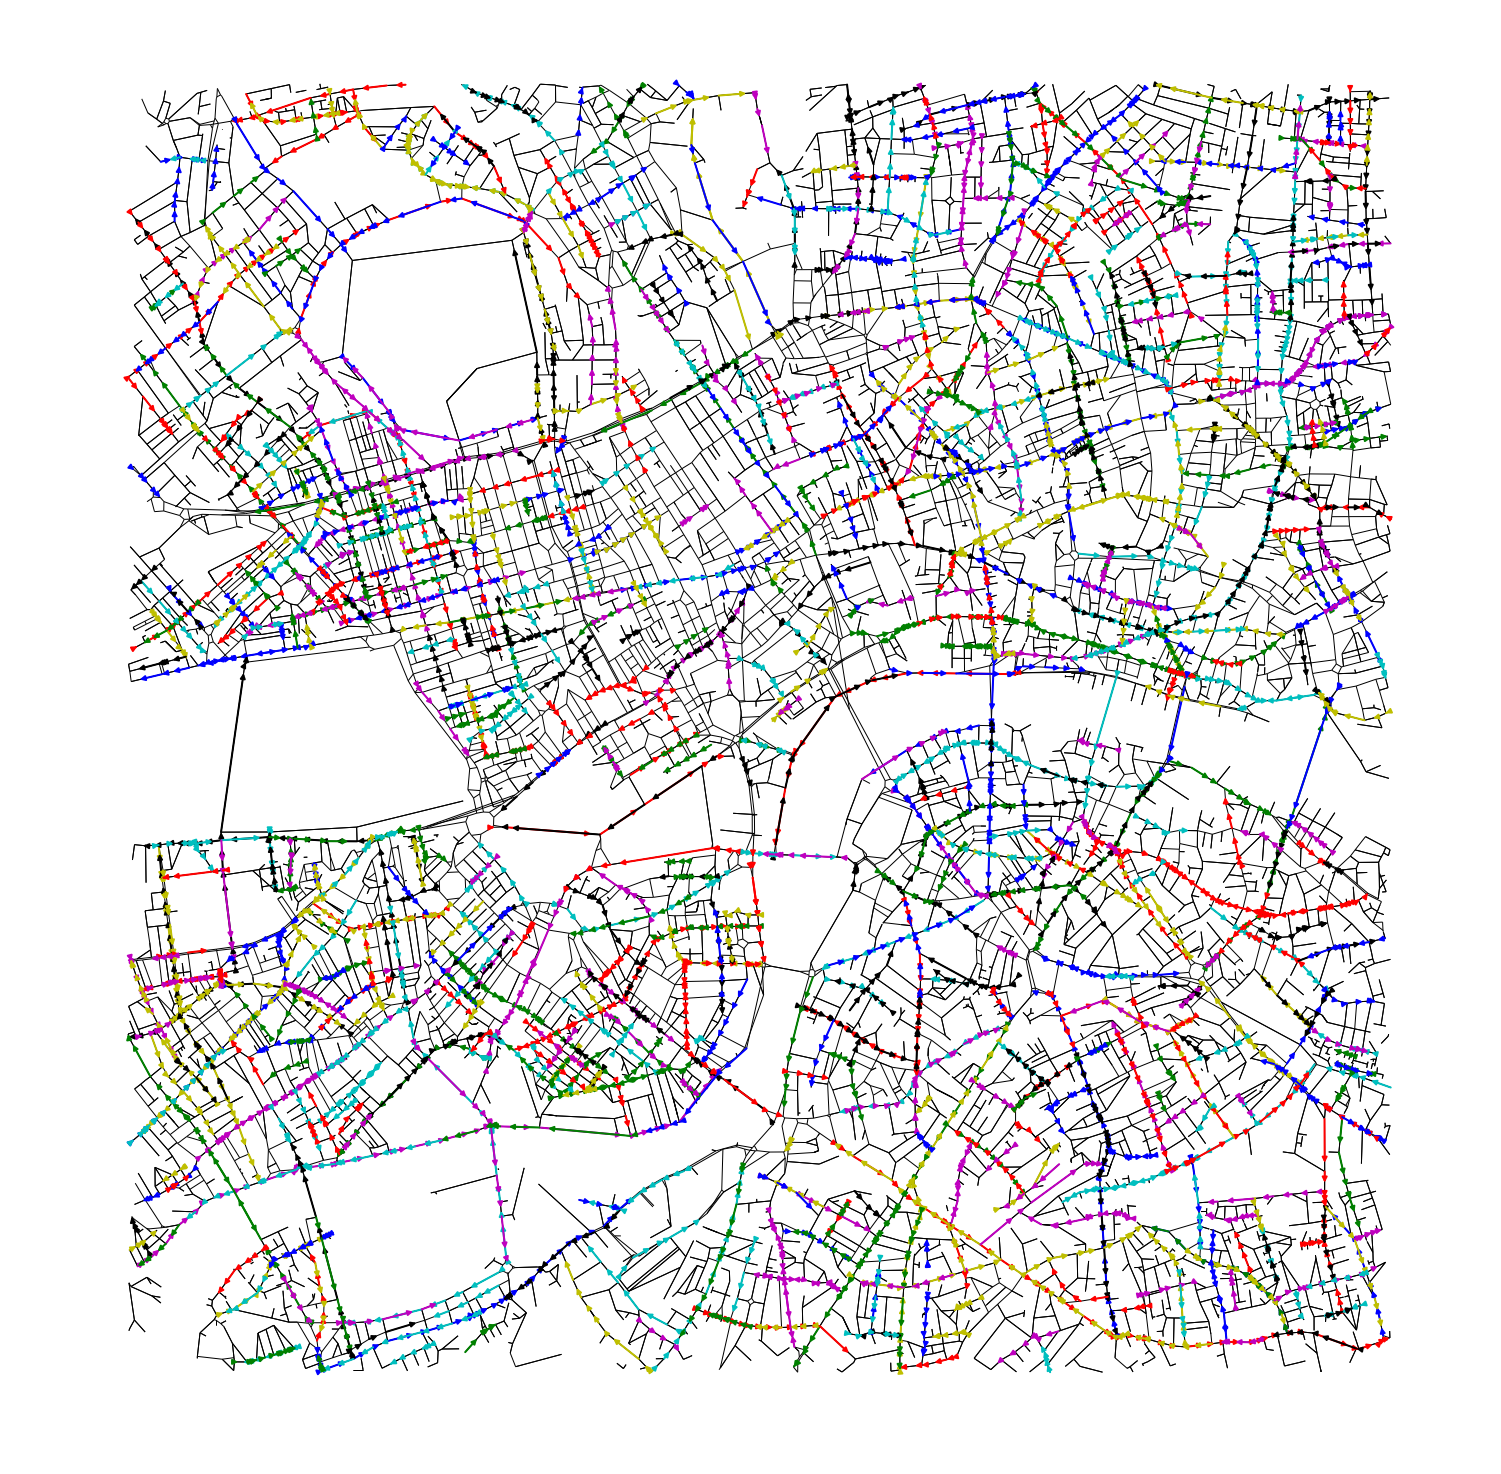

In [11]:
col = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
figure(figsize=(20,20))
nx.draw(G_ox,pos_list,node_color='k', node_size=0, arrows=False)
longest_paths = sorted(list(meta_edge_set.values()),key=len, reverse=True)[:1000]
for i, path in enumerate(longest_paths):
    path = [path[0][0]]+[p[1] for p in path]
    path_edges = zip(path,path[1:])
    #nx.draw_networkx_nodes(G,pos,nodelist=path,node_color='r', node_size=1)
    nx.draw_networkx_edges(G_ox,pos_list,edgelist=path_edges,edge_color=col[i%len(col)],width=2)
    
savefig("rectipaths.png")